In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Flatten, Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
labeled_train = pd.read_csv("labels.csv") # label.csv file is taken.
labeled_train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


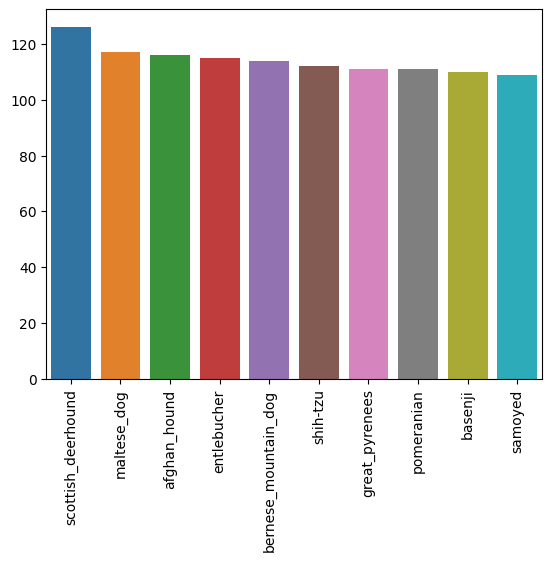

In [4]:
sns.barplot(x= labeled_train["breed"].value_counts()[:10].index, y= labeled_train["breed"].value_counts()[:10].values)
plt.xticks(rotation=90)
plt.show() # it seems data was divided balanced. 

In [5]:
labeled_train.isna().sum()

id       0
breed    0
dtype: int64

In [6]:
labeled_train.nunique()

id       10222
breed      120
dtype: int64

## Data Preprocessing

#####  preparing the data for training the model.

In [7]:
# We are taking the breeds that value_counts bigger than 100, so that we can reduce the runtime. 
breed_counts = labeled_train['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 100].index.tolist()
labeled_train = labeled_train[labeled_train['breed'].isin(included_breeds)].reset_index(drop=True)

In [8]:
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2184 non-null   object
 1   breed   2184 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [9]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

train_path = 'C:\\Users\\4242o\\Desktop\\Gloabal AI Deep Learning Bootcamp\\Mezuniyet Projesi\\train'

resized_images = []
for idx, filename in enumerate(labeled_train['id']):
    img_path = os.path.join(train_path, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

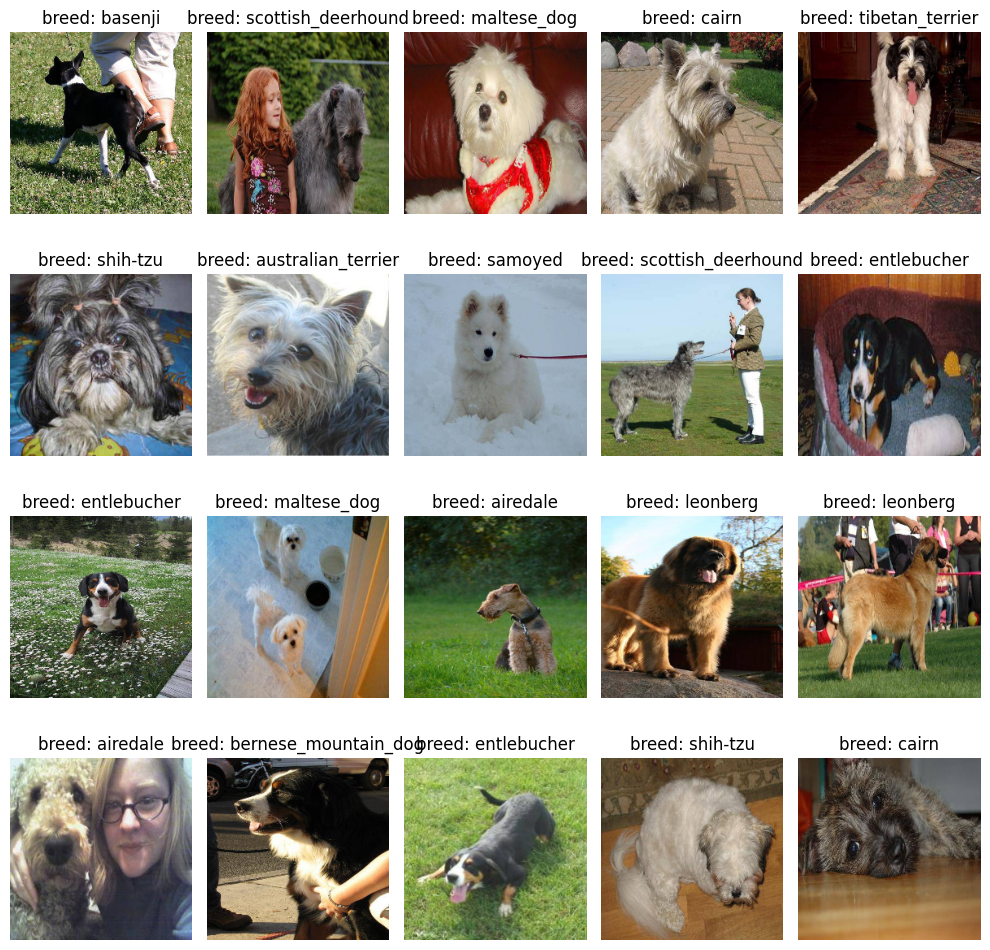

In [10]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.title(f"breed: {labeled_train.breed[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labeled_train['breed'])
new_labels = to_categorical(label_encoded)

In [12]:
X = resized_images_array
y = new_labels

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=30)
X_train.shape

(1856, 224, 224, 3)

In [14]:
X_val = X_train[1500:]
y_val = y_train[1500:]
X_train = X_train[:1500]
y_train = y_train[:1500]


In [15]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
X_train = X_train / 255
X_val = X_val / 255 
X_test = X_test / 255

In [17]:
y_train.shape

(1500, 20)

##### Building Model

In [21]:
model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    Dropout(0.2),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(224, activation='relu'),
    layers.Dense(20, activation='softmax')
])


In [22]:

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = 10)

Epoch 1/10
47/47 [==============================] - 100s 2s/step - loss: 3.0000 - accuracy: 0.0493 - val_loss: 2.9968 - val_accuracy: 0.0393
Epoch 2/10
47/47 [==============================] - 72s 2s/step - loss: 2.9942 - accuracy: 0.0613 - val_loss: 2.9974 - val_accuracy: 0.0393
Epoch 3/10
47/47 [==============================] - 69s 1s/step - loss: 2.9799 - accuracy: 0.0767 - val_loss: 2.9612 - val_accuracy: 0.0843
Epoch 4/10
47/47 [==============================] - 70s 1s/step - loss: 2.8241 - accuracy: 0.1107 - val_loss: 2.8902 - val_accuracy: 0.1320
Epoch 5/10
47/47 [==============================] - 70s 1s/step - loss: 2.7056 - accuracy: 0.1600 - val_loss: 2.7654 - val_accuracy: 0.1433
Epoch 6/10
47/47 [==============================] - 69s 1s/step - loss: 2.5284 - accuracy: 0.2120 - val_loss: 2.6088 - val_accuracy: 0.1826
Epoch 7/10
47/47 [==============================] - 69s 1s/step - loss: 2.3698 - accuracy: 0.2480 - val_loss: 2.5552 - val_accuracy: 0.1966
Epoch 8/10
47/47 [=

In [24]:
test_loss, best_test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nBest Test Accuracy:", best_test_acc)

11/11 - 3s - loss: 2.5668 - accuracy: 0.2439 - 3s/epoch - 230ms/step

Best Test Accuracy: 0.24390244483947754


In [32]:
predicts = model.predict(X_test)
best_predicted_classes = np.argmax(predicts, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 3s 268ms/step


In [27]:
best_predicted_classes

array([16,  3,  6, 18, 15,  2, 14, 14, 11, 14, 15, 19, 12,  2,  1, 15,  8,
       14, 10, 14,  2,  6, 15, 12,  2, 18, 13, 13, 13,  1,  7, 12, 16,  6,
        8, 12, 12, 13,  8,  5,  7, 13,  9, 13, 12, 16,  4,  2,  2,  3,  5,
       19, 13, 19, 14, 12, 13, 15,  0, 12,  0, 11,  8,  5, 13, 15,  2, 19,
        5,  3, 18, 12, 14, 12, 18,  0,  5,  5, 15,  2,  6, 16,  7, 15,  0,
       14, 18, 18,  5,  5, 15, 18, 14, 19, 13, 13,  3, 11,  9, 11,  5, 13,
       12,  8,  9, 18,  3, 15, 14, 15, 17,  7,  3,  8, 14, 12, 14, 10, 17,
       12, 15,  2, 15,  9, 14, 19,  2, 12,  0, 14, 15,  3, 11, 12, 13, 16,
       18, 15,  3,  2, 17,  1,  0, 17,  8, 14, 15,  5,  1,  2, 13, 13, 18,
       13,  2, 10, 15,  4, 12,  7, 13, 13, 15, 15, 17,  0, 15, 13,  6, 11,
        0, 16, 12, 15, 13, 10, 14, 13, 10, 12, 13, 13, 15,  2, 19, 17,  6,
       17,  8, 12, 12, 12, 15, 18,  8,  3, 15,  3, 11, 13,  6, 14, 12,  1,
        9, 13,  7,  7, 14, 11, 16,  2, 15,  1, 10, 17, 17,  3,  2,  2, 14,
       15, 12, 10,  6, 15

In [33]:
y_test_

array([ 9, 10, 11,  3,  0,  1, 14, 19, 17,  4,  9, 18,  2,  1, 14,  1,  1,
        8,  3, 12,  1,  6, 18, 15, 17,  3, 16, 13, 10, 13,  9, 12,  2,  6,
        8, 12,  9,  9,  5,  1,  0, 17, 10, 13, 15, 10, 15,  2, 12,  0, 14,
       15,  0,  8, 17, 12, 13,  6,  1, 12,  0, 11,  8,  5, 18, 13, 15,  1,
        5,  3, 19, 12,  7, 17,  0,  2,  4, 11, 18, 12,  6, 11, 10,  5,  0,
       14,  8,  4, 19,  5,  9,  4,  2,  1, 18, 11,  6, 11, 16,  8,  5, 13,
        4,  5,  9, 18,  3,  9,  0,  3, 10,  7,  0,  8,  0,  6, 14, 19,  4,
        7,  2,  0,  7,  0, 16, 14,  2, 10, 16,  7,  6,  4, 14, 13,  4, 18,
        4, 18,  4, 15,  7, 14,  4, 12,  5,  0, 18,  5, 17, 14, 19, 13,  5,
        2,  2, 16,  6,  4, 12, 10,  9,  0,  2,  9,  2, 18, 16, 13,  6, 11,
       17,  9,  2,  4, 10, 17,  2, 17,  0, 12, 19,  9, 16,  4, 18,  5,  6,
       17,  8,  8, 17,  1,  0, 16,  6,  9,  9,  3, 11, 18,  6,  5, 12,  0,
        2, 13, 17,  9,  1, 11, 16,  7, 10, 12, 18,  0,  7,  8, 11, 10,  2,
        9,  3,  0,  4,  1

In [28]:
predicts

array([[0.07230088, 0.00651495, 0.00027606, ..., 0.01415819, 0.04715649,
        0.06685597],
       [0.05101427, 0.04033435, 0.00819791, ..., 0.05328967, 0.0427731 ,
        0.01831077],
       [0.03264464, 0.00252305, 0.00029759, ..., 0.00762261, 0.12021376,
        0.06710971],
       ...,
       [0.01500416, 0.10977266, 0.04339378, ..., 0.01769525, 0.02626571,
        0.00902038],
       [0.06597608, 0.04342929, 0.00274735, ..., 0.0491146 , 0.16112211,
        0.05196643],
       [0.00601404, 0.00717555, 0.02829415, ..., 0.00842752, 0.14941989,
        0.01612792]], dtype=float32)

In [29]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
labeled_train["breed"].unique()

array(['basenji', 'scottish_deerhound', 'maltese_dog', 'cairn',
       'tibetan_terrier', 'shih-tzu', 'australian_terrier', 'samoyed',
       'entlebucher', 'airedale', 'leonberg', 'bernese_mountain_dog',
       'afghan_hound', 'miniature_pinscher', 'irish_wolfhound',
       'great_pyrenees', 'beagle', 'japanese_spaniel', 'pomeranian',
       'blenheim_spaniel'], dtype=object)

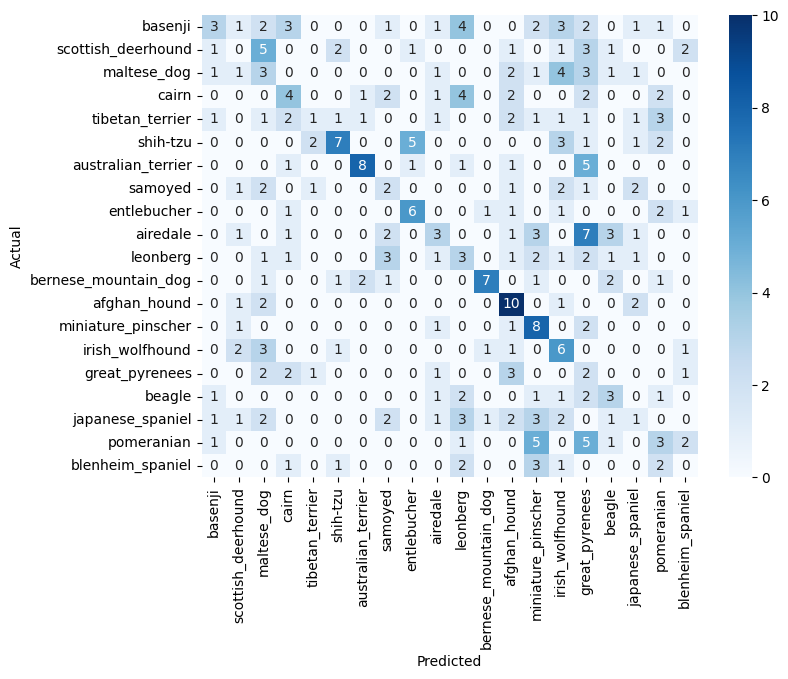

In [40]:
best_cm = confusion_matrix(y_test_, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Blues', xticklabels=labeled_train["breed"].unique(), yticklabels=labeled_train["breed"].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()